About Yahoo Finance API [Overview](http://thesimplesynthesis.com/article/finance-apis#overview)


Code [source](https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/)

SQL queries for YQL
https://github.com/cttn/Stockex

Yahoo finance tables
https://stackoverflow.com/questions/14795726/getting-data-from-yahoo-finance

In [5]:
# pip install pandas-datareader

import pandas as pd
from pandas_datareader import data, wb # Package and modules for importing data; this code may change depending on pandas version
import datetime
 
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

In [6]:
 import pandas_datareader as pdr

# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
#apple = wb.DataReader("AAPL", "yahoo", start, end)
apple = pdr.get_data_yahoo('AAPL')
type(apple)

pandas.core.frame.DataFrame

In [7]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.613066,123432400
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.660807,150476200
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.220825,138040000
2010-01-07,30.250000,30.285715,29.864286,30.082857,27.170504,119282800
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.351143,111902700


Populating the interactive namespace from numpy and matplotlib


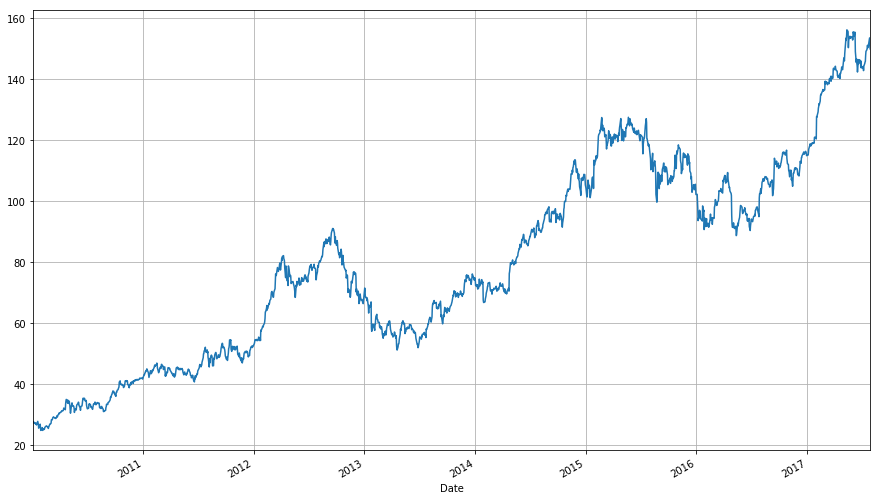

In [8]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
apple["Adj Close"].plot(grid = True) # Plot the adjusted closing price of AAPL


In [11]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator
    # import constants for the days of the week
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib.finance import candlestick_ohlc

In [12]:
# Creating the function to make a candlestick chart

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MO)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

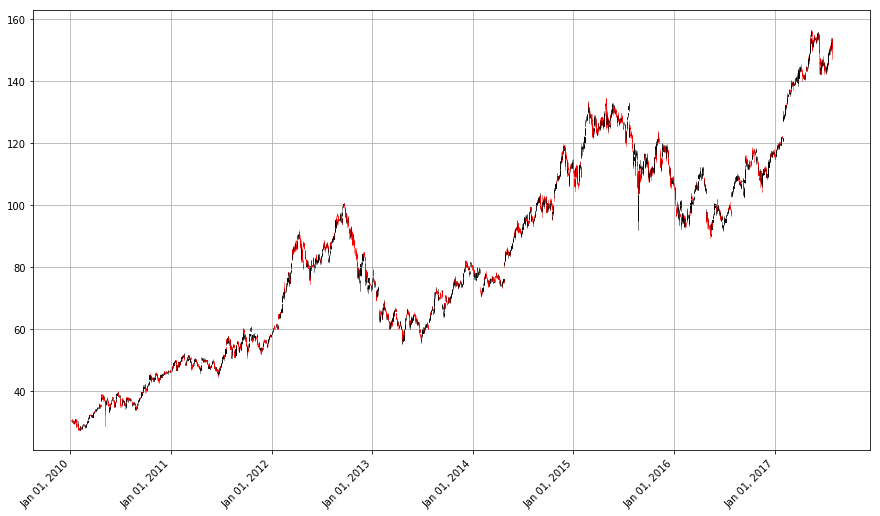

In [13]:
 
pandas_candlestick_ohlc(apple)

In [22]:
#apple = pdr.get_data_yahoo('AAPL')
microsoft = pdr.get_data_yahoo("MSFT")

In [23]:
#google = pdr.get_data_yahoo("GOOG", start, end)
google = pdr.get_data_yahoo("GOOG")
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})
 
stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2010-01-04,27.613066,312.204773,25.409840
2010-01-05,27.660807,310.829926,25.418049
2010-01-06,27.220825,302.994293,25.262056
2010-01-07,27.170504,295.940735,24.999338
2010-01-08,27.351143,299.885956,25.171749


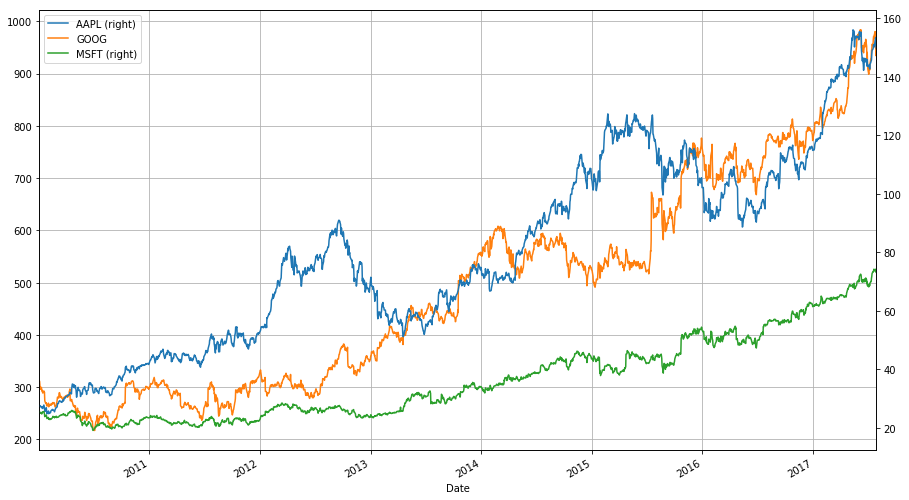

In [24]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)


In [25]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2010-01-04,1.000000,1.000000,1.000000
2010-01-05,1.001729,0.995596,1.000323
2010-01-06,0.985795,0.970499,0.994184
2010-01-07,0.983973,0.947906,0.983845
2010-01-08,0.990515,0.960543,0.990630


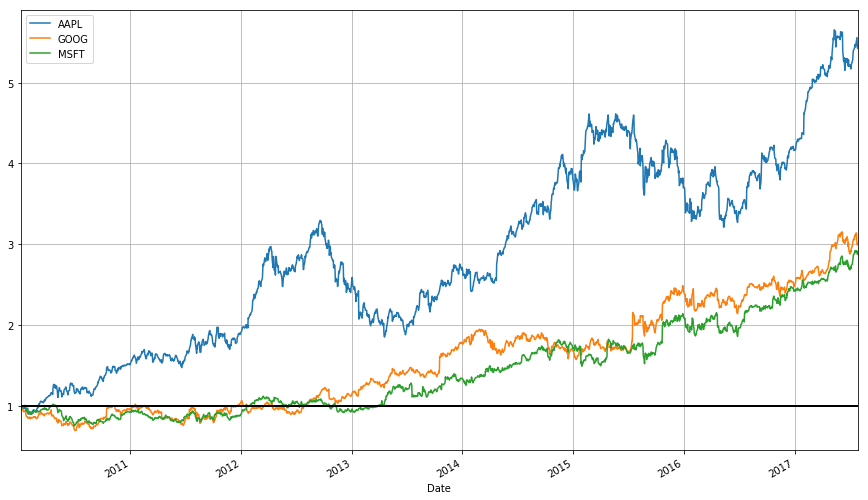

In [26]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [27]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2010-01-04,NaN,NaN,NaN
2010-01-05,0.001727,-0.004413,0.000323
2010-01-06,-0.016034,-0.025532,-0.006156
2010-01-07,-0.001850,-0.023555,-0.010454
2010-01-08,0.006626,0.013243,0.006873


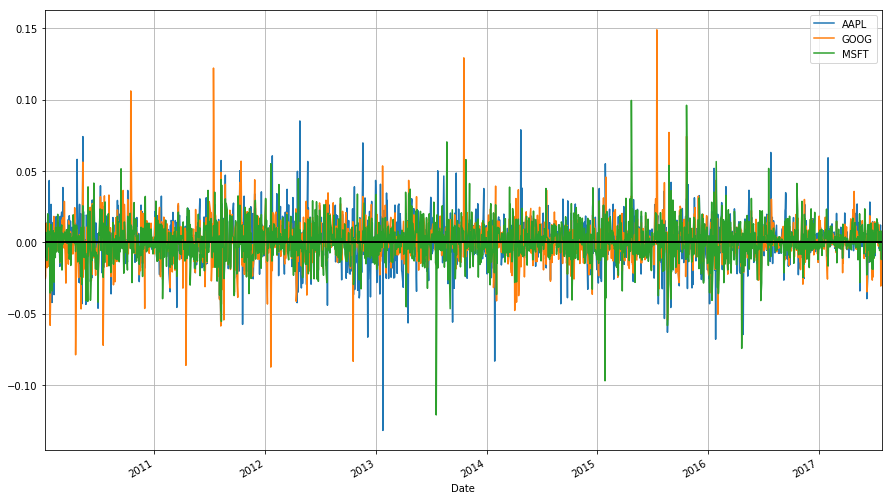

In [28]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

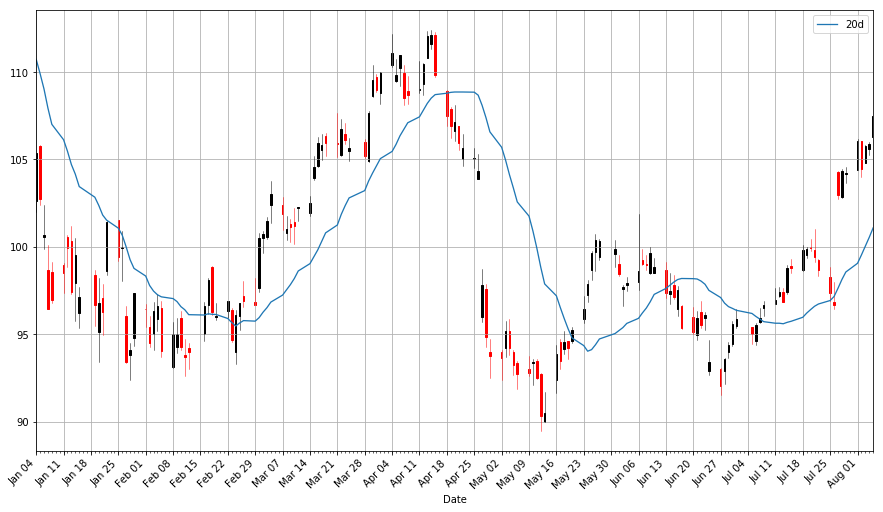

In [29]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

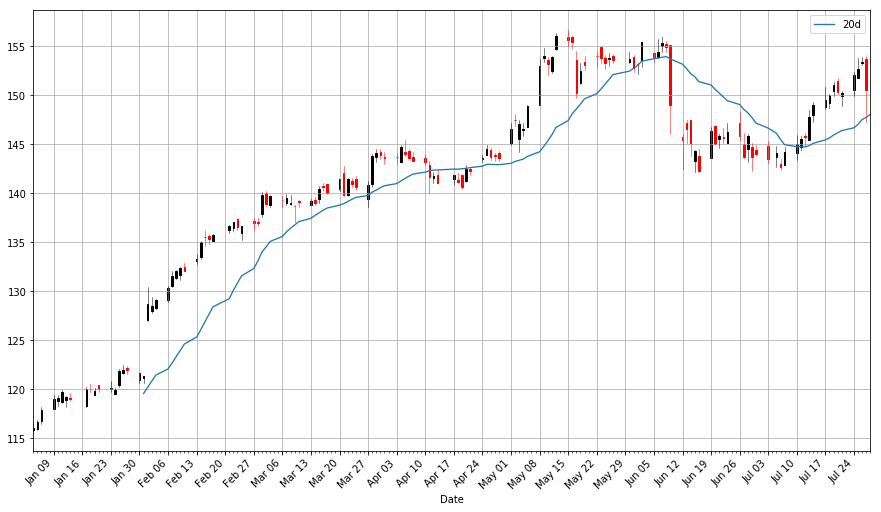

In [31]:
start = datetime.datetime(2017,1,1)
apple = pdr.get_data_yahoo("AAPL", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2017-01-04':'2017-08-07',:], otherseries = "20d")


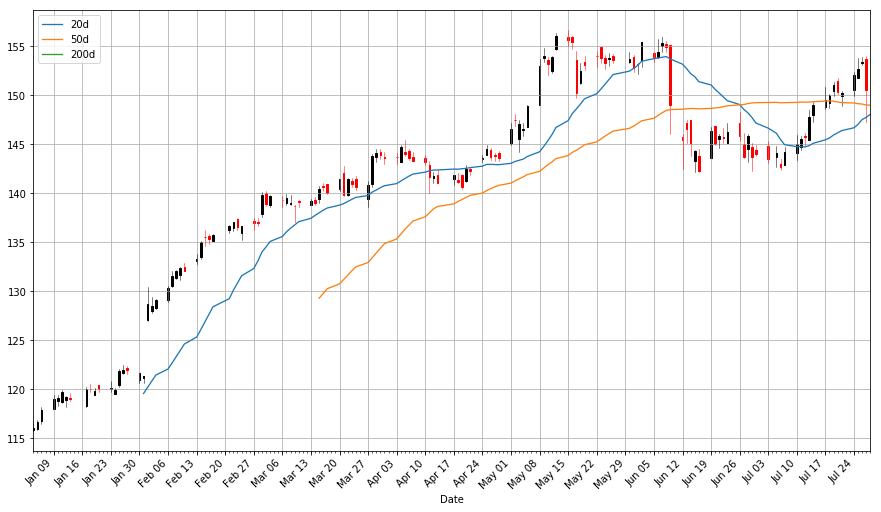

In [33]:
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple.loc['2017-01-04':'2017-08-07',:], otherseries = ["20d", "50d", "200d"])
